# The best rider and bike for a KOM on Strava

The structure of this blog is as follows.<br>
Recap and intro: power, mass and cdA<br>
Power versus V cubed<br>
Power to weight ratio Watts per kilo, alometry<br>
Mass versus gradient<br>
cd A rider, wheels, frame<br>



So far this series of articles has explored how seasonal variations in the weather affect the ability riders to post fast times on a Strava leaderboard. But in the end, is it not simply the strongest rider who holds the KOM? This blog looks at how the time to complete a segment is affected by three determinants relating specifically to the bike and rider: power, body mass and aerodynamic drag factors.<br>
It is helpful to bear in mind the following equation relating power, P, required to ride at velocity, V.<br>
Power = Drag_Factors x V<sup>3</sup> + Mechanical_Factors x V<br>
Aerodynamic drag factors include frontal area and drag coefficient of the rider and frame plus the drag of the wheels. The mechancial factors are due to rider weight, the gradient of the road and rolling resistance.  

In [195]:
# Calculate constant velocity for set of parameters
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import sys
sys.path.append('/Users/Gavin/Gavin/Jupyter/Weather')
from AirDensity import rhoCalc


# Better model of V accounting for wind
def solveV(Power=286, Grade=0.018, mr=74, Cd=0.5,  A=0.5, Br=0, Vw=4, Bw=90, Pressure=1020, Temp=15, DP=False, Humidity=False, Crr=0.005, Cxf=0.0491, df=0.337*2, Cxr=0.0491, dr=0.337*2, RS=0.25, mb=8, mfw=1.264, mrw=1.364, g=9.81, plotIt=False):
    rho = rhoCalc(Pressure=Pressure, Temp=Temp, DP=DP, Humidity=Humidity)
    theta = np.arctan(Grade)
    Drag_frontal = rho * A * Cd / 2
    Drag_fw = rho * np.pi * (Cxf * df**2) / 8
    Drag_rw = rho * np.pi * Cxr * dr**2 * (1-RS) / 8
    Drag = Drag_frontal + Drag_fw + Drag_rw
    Mech_g = (mr + mb + mfw + mrw) * g * np.sin(theta)
    Mech_rr = (mr + mb + mfw + mrw) * g * np.cos(theta) * Crr
    Mech = Mech_g + Mech_rr
    Ahw = Vw * np.cos((Bw-Br)*np.pi/180) # Apparent headwind

    coef = [0,0,0,0]
    coef[0] = Drag
    coef[1] = 3 * Drag * Ahw
    coef[2] = (3 * Drag * Ahw **2) + Mech
    coef[3] = Drag * Ahw **3 - Power
    if plotIt:
        plt.plot(np.arange(-50,50,0.1),np.polyval(coef,np.arange(-50,50,0.1)))
        plt.axhline(linewidth=1, color='r')

    # Solve for velocity V by taking the real root
    roots = np.roots(coef)
    v = max(roots[abs(roots.imag)<1e-3].real) # velocity an m / s
    return v, Drag_frontal, Drag_fw, Drag_rw, Mech_g, Mech_rr, rho



NameError: name 'init_notebook_mode' is not defined

Comparison against http://analyticcycling.com/ForcesSource_Page.html
He is measuring forces in gmf whereas I am calculating power in Watts. At 10m/s the conversion is g * v / 10000. If I just wanted to display my results in Newtons, I'd just multiply/divide by velocity, v.

In [143]:
g=9.81
Grade = 0.05
v, Drag_frontal, Drag_fw, Drag_rw, Mech_g, Mech_rr, rho = solveV(Power=5866*9.8*10/1000, Grade=Grade, mr=65, Cd=0.5,  A=0.5, Br=0, Vw=0, Bw=90, Pressure=1019.25, Temp=15, DP=False, Humidity=False, Crr=0.004, Cxf=0.0491, df=0.337*2, Cxr=0.0491, dr=0.337*2, RS=0.25, mb=8, mfw=1.264, mrw=1.804, g=9.81, plotIt=False)
print ('Everything expressed in gmf units to cross check versus website link')
print ('Grade = {:.2f}% \nV = {:.2f} m/s, \nDrag_frontal = {:0.1f} \nDrag_fw = {:0.1f} \nDrag_rw = {:0.1f} \nMech_g = {:0.1f} \nMech_rr = {:0.1f} \nrho = {:.4f}'.format (Grade*100, v, Drag_frontal*v**3*(1000/g/v), Drag_fw*v**3*(1000/g/v), Drag_rw*v**3*(1000/g/v), Mech_g*v*(1000/g/v), Mech_rr*v*(1000/g/v), rho))

Everything expressed in gmf units to cross check versus website link
Grade = 5.00% 
V = 10.00 m/s, 
Drag_frontal = 1563.4 
Drag_fw = 109.6 
Drag_rw = 82.2 
Mech_g = 3798.7 
Mech_rr = 303.9 
rho = 1.2260


In [144]:
Grade = 0.05
v, Drag_frontal, Drag_fw, Drag_rw, Mech_g, Mech_rr, rho = solveV(Power=575, Grade=Grade, mr=65, Cd=0.5,  A=0.5, Br=0, Vw=0, Bw=90, Pressure=1019.25, Temp=15, DP=False, Humidity=False, Crr=0.004, Cxf=0.0491, df=0.337*2, Cxr=0.0491, dr=0.337*2, RS=0.25, mb=8, mfw=1.264, mrw=1.804, g=9.81, plotIt=False)
print ('Everything expressed in Watts')
print ('Grade = {:.2f}% \nV = {:.2f} kph, \nDrag_frontal = {:0.1f} \nDrag_fw = {:0.1f} \nDrag_rw = {:0.1f} \nMech_g = {:0.1f} \nMech_rr = {:0.1f} \nrho = {:.4f}'.format (Grade*100, v*3.6, Drag_frontal*v**3, Drag_fw*v**3, Drag_rw*v**3, Mech_g*v, Mech_rr*v, rho))

Everything expressed in Watts
Grade = 5.00% 
V = 36.02 kph, 
Drag_frontal = 153.5 
Drag_fw = 10.8 
Drag_rw = 8.1 
Mech_g = 372.8 
Mech_rr = 29.8 
rho = 1.2260


All this is much easier if we enter v as a known variable, rather than power. But the problem is that power now becomes a variable in the output. These calculations are all cross checked against this spreadsheet /Users/Gavin/Gavin/Jupyter/Strava/PowerBreakdown.xlsx and the http://analyticcycling.com/ForcesSource_Page.html website.I also looked at https://www.gribble.org/cycling/power_v_speed.html#physics

In [145]:
v = 10

def powerBreakdown(v=10, Grade=0.0, mr=65, Cd=0.5,  A=0.5, rho=1.226,  Crr=0.004, Cxf=0.0491, df=0.337*2, Cxr=0.0491, dr=0.337*2, RS=0.25, mb=8, mfw=1.264, mrw=1.804, g=9.81):
    theta = np.arctan(Grade)
    Drag_frontal = rho * A * Cd / 2 * v**3
    Drag_fw = rho * np.pi * (Cxf * df**2) / 8 * v**3
    Drag_rw = rho * np.pi * Cxr * dr**2 * (1-RS) / 8 * v**3
    Drag = Drag_frontal + Drag_fw + Drag_rw 
    Mech_g = (mr + mb + mfw + mrw) * g * np.sin(theta) * v
    Mech_rr = (mr + mb + mfw + mrw) * g * np.cos(theta) * Crr * v
    Mech = Mech_g + Mech_rr
    Power = Drag + Mech
    x = np.array([Power, Drag_frontal, Drag_fw, Drag_rw, Mech_g, Mech_rr])
    return x




Compare 60kg climber v 80kg TT on the flat and uphill

In [171]:
mrF = 80
mrN = 60
AF = 0.5
AN = 0.5 * (mrN/mrF)**(2/3)


print('Powers for equivalent speeds on flat')
Grade = 0.0
f=1
[mr, A, P] = [mrF, AF, 275.7]
print(solveV(Power=P, Grade=Grade, mr=mr, Cd=0.5,  A=A, Br=0, Vw=0, Bw=90, Pressure=1019.25, Temp=15, DP=False, Humidity=False, Crr=0.004, Cxf=0.0491, df=0.337*2, Cxr=0.0491, dr=0.337*2, RS=0.25, mb=8, mfw=1.264, mrw=1.804, g=9.81, plotIt=False)[0]*3.6)
[mr, A, P] = [mrN, AN, 230.3]
print(solveV(Power=P, Grade=Grade, mr=mr, Cd=0.5,  A=A, Br=0, Vw=0, Bw=90, Pressure=1019.25, Temp=15, DP=False, Humidity=False, Crr=0.004, Cxf=0.0491, df=0.337*2, Cxr=0.0491, dr=0.337*2, RS=0.25, mb=8, mfw=1.264, mrw=1.804, g=9.81, plotIt=False)[0]*3.6)
print(275.7*f,275.7*f/80,230.3*f,230.3*f/60 )

print('Equivalent powers up 5%')
Grade = 0.05
[mr, A, P] = [mrF, AF, 275.7]
print(solveV(Power=P, Grade=Grade, mr=mr, Cd=0.5,  A=A)[0]*3.6)
[mr, A, P] = [mrN, AN, 230.3]
print(solveV(Power=P, Grade=Grade, mr=mr, Cd=0.5,  A=A)[0]*3.6)

f=1.5
print('Equivalent powers*',f,' up 5%')
Grade = 0.05
[mr, A, P] = [mrF, AF, 275.7*f]
print(solveV(Power=P, Grade=Grade, mr=mr, Cd=0.5,  A=A)[0]*3.6)
[mr, A, P] = [mrN, AN, 230.3*f]
print(solveV(Power=P, Grade=Grade, mr=mr, Cd=0.5,  A=A)[0]*3.6)
print(275.7*f,275.7*f/80,230.3*f,230.3*f/60 )

f=1.66
print('Equivalent powers*',f,' up 10%')
Grade = 0.1
[mr, A, P] = [mrF, AF, 275.7*f]
print(solveV(Power=P, Grade=Grade, mr=mr, Cd=0.5,  A=A)[0]*3.6)
[mr, A, P] = [mrN, AN, 230.3*f]
print(solveV(Power=P, Grade=Grade, mr=mr, Cd=0.5,  A=A)[0]*3.6)
print(275.7*f,275.7*f/80,230.3*f,230.3*f/60 )

f=1.5
print('Equivalent powers*',f,' back on flat')
Grade = 0.0
[mr, A, P] = [mrF, AF, 275.7*f]
print(solveV(Power=P, Grade=Grade, mr=mr, Cd=0.5,  A=A)[0]*3.6)
[mr, A, P] = [mrN, AN, 230.3*f]
print(solveV(Power=P, Grade=Grade, mr=mr, Cd=0.5,  A=A)[0]*3.6)
print(275.7*f,275.7*f/80,230.3*f,230.3*f/60 )


print('Wiggins')
[mr, A, v, Grade] = [72, .32, 54.5/3.6, 0]
pB = powerBreakdown(v=v, Grade=Grade, mr=mr, A=A)
print(pB,pB/sum(pB[1:])*100, pB[0]/mr)

    

Powers for equivalent speeds on flat
39.9994629071
39.9998752152
275.7 3.44625 230.3 3.8383333333333334
Equivalent powers up 5%
18.5785688751
19.5730820948
Equivalent powers* 1.5  up 5%
25.8083010311
26.9226835351
413.54999999999995 5.169375 345.45000000000005 5.757500000000001
Equivalent powers* 1.66  up 10%
17.0307985908
18.0939494015
457.662 5.720775 382.298 6.3716333333333335
Equivalent powers* 1.5  back on flat
45.9004582621
45.8949112371
413.54999999999995 5.169375 345.45000000000005 5.757500000000001
Wiggins
[ 454.85056505  340.30040166   37.25921028   27.94440771    0.           49.3465454 ] [ 100.           74.81586873    8.19152775    6.14364582    0.           10.8489577 ] 6.31736895897


Compare their speeds on flat and uphill, both doing 5Watts/kg. Bigger rider always does better if riding at equivalent Watt/kg, but not as a percentage of cruising speed. Hypthesis is that some cruising speed is FTP and riding at 57% over FTP is much harder than riding at 50% over FTP, due to exponential accumulation of lactate. 

In [147]:
Grade=0
[mr, A] = [mrF, AF]
print(solveV(Power=mr*5, Grade=Grade, mr=mr, A=A, Crr=0.004)[0]*3.6)
[mr, A] = [mrN, AN]
print(solveV(Power=mr*5, Grade=Grade, mr=mr, A=A, Crr=0.004)[0]*3.6)
Grade=0.2
[mr, A] = [mrF, AF]
print(solveV(Power=mr*5, Grade=Grade, mr=mr, A=A, Crr=0.004)[0]*3.6)
[mr, A] = [mrN, AN]
print(solveV(Power=mr*5, Grade=Grade, mr=mr, A=A, Crr=0.004)[0]*3.6)


45.8092053812
44.0339205848
8.05779673017
7.75452833899


In [135]:
powerDict = {}
power = 250
for gr in np.arange(-0.1,0.11,0.01):
    v, Drag_frontal, Drag_fw, Drag_rw, Mech_g, Mech_rr, rho = solveV(Power=power, Grade=gr, mr=75, Cd=0.5,  A=0.5, Br=0, Vw=0, Bw=90, Pressure=1019.25, Temp=15, DP=False, Humidity=False, Crr=0.004, Cxf=0.0491, df=0.337*2, Cxr=0.0491, dr=0.337*2, RS=0.25, mb=8, mfw=1.264, mrw=1.804, g=9.81, plotIt=False)
    powerDict[gr] = [v*3.6, power, Drag_frontal*v**3, Drag_fw*v**3, Drag_rw*v**3, Mech_g*v, Mech_rr*v]
    
powerComp = pd.DataFrame(powerDict).T
powerComp.columns = ['v', 'Power', 'Drag_frontal', 'Drag_fw', 'Drag_rw', 'Mech_g', 'Mech_rr']
powerComp.head()

,v,Power,Drag_frontal,Drag_fw,Drag_rw,Mech_g,Mech_rr
-0.10,1.190253,250.0,0.005539,0.000388,0.000291,-27.777087,277.770869
-0.09,1.176066,250.0,0.005343,0.000374,0.000281,-24.724681,274.718683
-0.08,1.162303,250.0,0.005158,0.000361,0.000271,-21.738627,271.732837
-0.07,1.148948,250.0,0.004982,0.000349,0.000262,-18.816783,268.811190
-0.06,1.135991,250.0,0.004815,0.000337,0.000253,-15.957102,265.951696


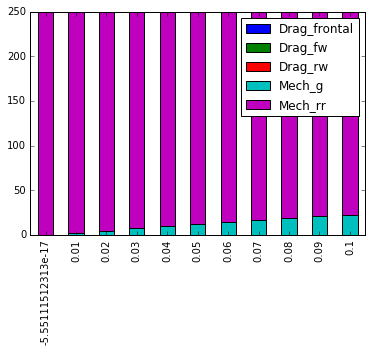

AttributeError: 'function' object has no attribute 'v'

In [136]:
powerComp[(powerComp.index>-0.01) ][['Drag_frontal', 'Drag_fw', 'Drag_rw', 'Mech_g', 'Mech_rr']].plot.bar(ylim=(0,power),stacked=True, )
plt.show()
powerBreakdown.v[(powerComp.index>-0.01) ].plot()

In [ ]:
ax = powerComp[['Drag_frontal', 'Drag_fw', 'Drag_rw', 'Mech_g', 'Mech_rr']].plot.bar()
#powerBreakdown.v.plot(secondary_y=True,linestyle='-', marker='o',ax=ax)


In [ ]:
30/3.6

Sample segment <a href="https://www.strava.com/segments/610040" target="_blank">Tour de Richmond Park</a>

## Analyse a selection of Strava segments across the UK

Draw a box around England, Wales and some of Scotland (50,-6) to (56,+2). Divide this up into smaller boxes and pull in data from popular segments in each box. Run the code once and pickle the results.


In [179]:
#from Strava_Download import get_strava_explore_segments

#import numpy as np
#segment_data = pd.DataFrame()
#for lat in np.arange(50,56,0.5):
#    for lon in np.arange(-6,2,0.5):
#        print(lat,lon)
#        df = get_strava_explore_segments(coords=[(lat,lon),(lat+0.5,lon+0.5)])
#        segment_data = segment_data.append(df,ignore_index=True)
#segment_data
#segment_data.to_pickle('PopularSegmentsUK.pkl')

segment_data = pd.read_pickle('PopularSegmentsUK.pkl')

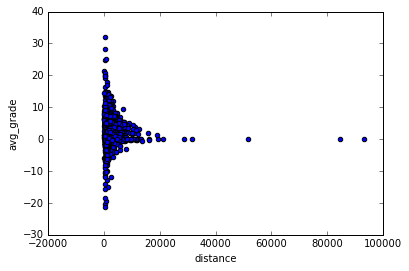

In [185]:
segment_data.plot.scatter(x='distance', y='avg_grade')

In [186]:
segment_data.describe()

,id,climb_category,avg_grade,elev_difference,distance
count,1.364000e+03,1364.000000,1364.000000,1364.000000,1364.000000
mean,4.633195e+06,0.450880,3.174267,71.434677,2344.678299
std,3.489383e+06,0.750499,4.818399,80.254849,4405.181101
min,2.575050e+05,0.000000,-21.200000,0.000000,93.400000
25%,1.324762e+06,0.000000,0.000000,13.375000,713.900000
50%,4.110420e+06,0.000000,3.100000,41.800000,1368.750000
75%,6.973239e+06,1.000000,5.900000,102.725000,2722.975000
max,1.370206e+07,4.000000,31.900000,645.400000,93324.700000


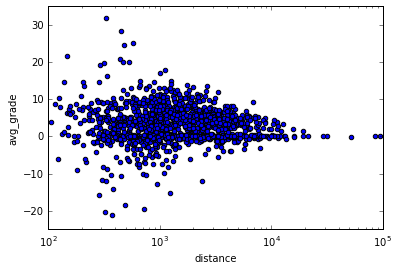

In [191]:
ax = segment_data.plot.scatter(x='distance', y='avg_grade')
ax.set_xscale("log", nonposx='clip')
ax.set_ylim(-25,35);
ax.set_xlim(100,100000);


In [193]:
segment_data.head()

,id,name,climb_category,climb_category_desc,avg_grade,elev_difference,distance
0,5432521.0,Segment,1.0,4,24.7,118.2,478.2
1,4782364.0,Three Tunnel Dash,0.0,NC,3.7,7.1,193.6
2,1060760.0,Eagles Nest Slog,1.0,4,4.4,84.1,1842.7
3,11756862.0,Up and away from Lands End,0.0,NC,4.2,17.8,427.9
4,1077299.0,Rosewall Hill,0.0,NC,3.9,76.5,1774.9


Let's try to produce a nice Plotly scatter

In [242]:
len(segment_data)

1364

In [205]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True)


In [241]:
iplot({
    'data':[Scatter(x=segment_data.distance, y=segment_data.avg_grade, text=segment_data.name, 
               mode='markers', marker=Marker(color='blue', size=5, opacity=0.8)),
           Scatter(x=[1500,20000,100],y=[20,2,-3],mode='text',text=['Climber', 'TTer', 'Sprinter'],
                   textfont=dict(size=20,color='red'))],
    'layout':Layout(title='Popular Strava Segments in the UK: Gradient v Distance',
                    xaxis=XAxis(title='Distance in metres', type='log'), 
                    yaxis=YAxis(title='Downhill        Grade %            Uphill'),
                   showlegend=False)
        },
      show_link=False)
